#  Introduction to Reproducible Machine Learning in Python

## Tutorial Goals

This is a tutorial for Introduction to Reproducible Machine Learning in Python at [Good Tech Fest](https://www.goodtechfest.com/) Data Science Day November 2020. We will be working with dengue fever data from the [DengAI: Predicting Disease Spread](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/) practice machine learning competition on DrivenData.

This notebook is adapted from the [benchmark walkthrough blog post](https://www.drivendata.co/blog/dengue-benchmark/). This tutorial will walk you through the competition. We will show you how to load the data and do a quick exploratory analysis. Then, we will train a simple model, make some predictions, and then submit those predictions to the competition.

A secondary goal is to introduce tools and best practices for reproducibility along the way. These are our main tools, some of which we've already introduced:

1. Reproducible environments with [conda](https://docs.conda.io/en/latest/), and environment manager.
2. A standardized, flexible project structure with [Cookie Cutter Data Science](https://drivendata.github.io/cookiecutter-data-science/).
2. Easy code review and change tracking with [nbautoexport](https://github.com/drivendataorg/nbautoexport).
3. [Jupyter](https://jupyter.org/) notebooks/lab for [literate programming](https://en.wikipedia.org/wiki/Literate_programming).
4. [scikit-learn](https://scikit-learn.org/) for self-contained, reusable ML pipelines

## Problem Introduction
----------------------

Dengue fever is bad. It's real bad. Dengue is a mosquito-borne disease that occurs in tropical and sub-tropical parts of the world. In mild cases, symptoms are similar to the flu: fever, rash and muscle and joint pain. But severe cases are dangerous, and dengue fever can cause severe bleeding, low blood pressure and even death.

Because it is carried by mosquitoes, the transmission dynamics of dengue are related to climate variables such as temperature and precipitation. Although the relationship to climate is complex, a growing number of scientists argue that climate change is likely to produce distributional shifts that will have significant public health implications worldwide.

We've [launched a competition](https://www.drivendata.org/competitions/44/) to use open data to predict the occurrence of Dengue based on climatological data. Here's a look at the data and how to get started!

### Import our tools and data

As always, we begin with the sacred `import`'s of data science:

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# turn off warnings just for the sake of this tutorial
from warnings import filterwarnings
filterwarnings('ignore')

## A Tale of Two Cities

![](https://community.drivendata.org/uploads/default/original/1X/4c3a8204d1715b5e2ee24da78abbad1515eccd5f.png)

This dataset has two cities in it: San Juan, Puerto Rico (right) and Iquitos, Peru (left). Since we hypothesize that the spread of dengue may follow different patterns between the two, we will divide the dataset, train separate models for each city, and then join our predictions before making our final submission.

As part of the [Cookiecutter Data Science](https://drivendata.github.io/cookiecutter-data-science/) project structure, we recommend keeping data in a `data/` directory, and further having a `data/raw/` subdirectory where the raw data lives unchanging.

In [2]:
PROJ_ROOT = Path().resolve().parent
DATA_DIR = PROJ_ROOT / "data" / "raw"
print("PROJ_ROOT :", PROJ_ROOT)
print("DATA_DIR :", DATA_DIR)

PROJ_ROOT : /Users/jqi/repos/intro-to-reproducible-ml
DATA_DIR : /Users/jqi/repos/intro-to-reproducible-ml/data/raw


Let's load the data from that path and take a look at our features.

In [3]:
# load the provided data

train_features = pd.read_csv(DATA_DIR / 'dengue_features_train.csv',
                             index_col=[0,1,2])

train_labels = pd.read_csv(DATA_DIR / 'dengue_labels_train.csv',
                           index_col=[0,1,2])

In [4]:
train_features

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear                                                           
sj   1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
          19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
          20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
          21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
          22              1990-05-28  0.196200  0.262200  0.251200  0.247340   
...                              ...       ...       ...       ...       ...   
iq   2010 21              2010-05-28  0.342750  0.318900  0.256343  0.292514   
          22              2010-06-04  0.160157  0.160371  0.136043  0.225657   
          23              2010-06-11  0.247057  0.146057  0.250357  0.233714   
          24              2010-06-18  0.333914  0.245771  0.278886  0.325486   
          25              2010-06-25  0.298186  0.232971  0.274214  0.315757   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city year weekofyear                                                
sj   1990 18                         12.42             297.572857   
          19                         22.82             298.211429   
          20                         34.54             298.781429   
          21                         15.36             298.987143   
          22                          7.52             299.518571   
...                                    ...                    ...   
iq   2010 21                         55.30             299.334286   
          22                         86.47             298.330000   
          23                         58.94             296.598571   
          24                         59.67             296.345714   
          25                         63.22             298.097143   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city year weekofyear                                                       
sj   1990 18                     297.742857                   292.414286   
          19                     298.442857                   293.951429   
          20                     298.878571                   295.434286   
          21                     299.228571                   295.310000   
          22                     299.664286                   295.821429   
...                                     ...                          ...   
iq   2010 21                     300.771429                   296.825714   
          22                     299.392857                   296.452857   
          23                     297.592857                   295.501429   
          24                     297.521429                   295.324286   
          25                     299.835714                   295.807143   

                      reanalysis_max_air_temp_k  ...  \
city year weekofyear                             ...   
sj   1990 18                              299.8  ...   
          19                              300.9  ...   
          20                              300.5  ...   
          21                              301.4  ...   
          22                              301.9  ...   
...                                         ...  ...   
iq   2010 21                              309.7  ...   
          22                              308.5  ...   
          23                              305.5  ...   
          24                              306.1  ...   
          25                              307.8  ...   

                      reanalysis_precip_amt_kg_per_m2  \
city year weekofyear                                    
sj   1990 18                                    32.00   
          19                                    17.94   
          20                                    26.10   
          21                                    13.90   
          22          

In [5]:
train_labels

total_cases
city year weekofyear             
sj   1990 18                    4
          19                    5
          20                    4
          21                    3
          22                    6
...                           ...
iq   2010 21                    5
          22                    8
          23                    1
          24                    1
          25                    4

[1456 rows x 1 columns]

Since we suspect that the dengue fever patterns will be different for each city, let's separate the data using the `city` index.

In [6]:
# Separate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

### Data Exploration

Now that we've loaded up our data, we can start to explore what it looks like.

In [7]:
print('San Juan')
print('features: ', sj_train_features.shape)
print('labels  : ', sj_train_labels.shape)
print()
print('Iquitos')
print('features: ', iq_train_features.shape)
print('labels  : ', iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


The [problem description](https://www.drivendata.org/competitions/44/page/82/) gives a good overview of the available variables, but we'll look at the head and types of the data here as well:

In [8]:
sj_train_features.head()

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
     19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
     20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
     21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
     22              1990-05-28  0.196200  0.262200  0.251200  0.247340   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
1990 18                         12.42             297.572857   
     19                         22.82             298.211429   
     20                         34.54             298.781429   
     21                         15.36             298.987143   
     22                          7.52             299.518571   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
1990 18                     297.742857                   292.414286   
     19                     298.442857                   293.951429   
     20                     298.878571                   295.434286   
     21                     299.228571                   295.310000   
     22                     299.664286                   295.821429   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
1990 18                              299.8  ...   
     19                              300.9  ...   
     20                              300.5  ...   
     21                              301.4  ...   
     22                              301.9  ...   

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                                    
1990 18                                    32.00   
     19                                    17.94   
     20                                    26.10   
     21                                    13.90   
     22                                    12.20   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
1990 18                                     73.365714   
     19                                     77.368571   
     20                                     82.052857   
     21                                     80.337143   
     22                                     80.460000   

                 reanalysis_sat_precip_amt_mm  \
year weekofyear                                 
1990 18                                 12.42   
     19                                 22.82   
     20                                 34.54   
     21                                 15.36   
     22                                  7.52   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
1990 18                                      14.012857           2.628571   
     19                                      15.372857           2.371429   
     20                                      16.848571           2.300000   
     21                                      16.672857           2.428571   
     22                                      17.210000           3.014286   

                 station_avg_temp_c  station_diur_temp_rng_c  \
year weekofyear                                                
1990 18                   25.442857                 6.900000   
     19                   26.714286                 6.371429   
     20                   26.714286                 6.485714   
     21                   27.471429                 6.771429   
     22                   28.942857                 9.371429   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  
year weeko

In [9]:
sj_train_features.dtypes

week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rng_c                  float64
station_max_temp_c                       float64
station_min_temp_c                       float64
station_precip_mm   

There are _a lot_ of climate variables here, but the first thing that we'll note is that the `week_start_date` is included in the feature set. This makes it easier for competitors to create time based features, but for this first-pass model, we'll drop that column since we shouldn't use it as a feature in our model.

In [10]:
# Remove `week_start_date` string.
sj_train_features.drop('week_start_date', axis=1, inplace=True)
iq_train_features.drop('week_start_date', axis=1, inplace=True)

Next, let's check to see if we are missing any values in this dataset:

In [11]:
# Null check
pd.isnull(sj_train_features).any()

ndvi_ne                                  True
ndvi_nw                                  True
ndvi_se                                  True
ndvi_sw                                  True
precipitation_amt_mm                     True
reanalysis_air_temp_k                    True
reanalysis_avg_temp_k                    True
reanalysis_dew_point_temp_k              True
reanalysis_max_air_temp_k                True
reanalysis_min_air_temp_k                True
reanalysis_precip_amt_kg_per_m2          True
reanalysis_relative_humidity_percent     True
reanalysis_sat_precip_amt_mm             True
reanalysis_specific_humidity_g_per_kg    True
reanalysis_tdtr_k                        True
station_avg_temp_c                       True
station_diur_temp_rng_c                  True
station_max_temp_c                       True
station_min_temp_c                       True
station_precip_mm                        True
dtype: bool

Let's plot one of our features to get a sense of what it looks like.

Text(0.5, 0, 'Time')

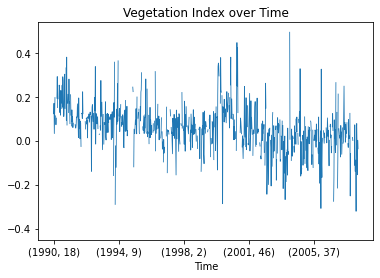

In [12]:
(sj_train_features
     .ndvi_ne
     .plot
     .line(lw=0.8))

plt.title('Vegetation Index over Time')
plt.xlabel('Time')

Since these are time-series, we can see the gaps where there are `NaN`s by plotting the data. Since we can't build a model without those values, we'll take a simple approach and just fill those values with the most recent value that we saw up to that point. This is probably a good part of the problem to improve your score by getting smarter.

In [13]:
# impute data using the forward fill method (propagate last valid observation forward to next valid)
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)

pd.isnull(sj_train_features).any()

ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_precip_mm                        False
dtype: bool

## Distribution of labels

Our target variable, `total_cases` is a non-negative integer, which means we're looking to make some **count predictions**. Let's see how our labels are distributed!

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f97cba096a0>]],
      dtype=object)

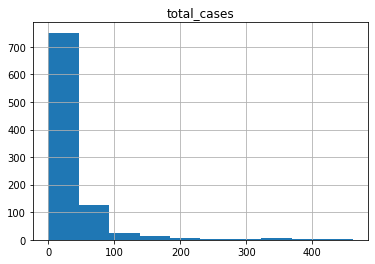

In [14]:
sj_train_labels.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f97c6014190>]],
      dtype=object)

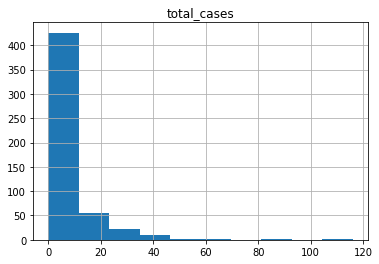

In [15]:
iq_train_labels.hist()

These sorts of right-skewed distributions are pretty typical for count data.

## Which inputs strongly correlate with `total_cases`?

Our next step in this process will be to select a subset of features to include in our regression. Our primary purpose here is to get a better understanding of the problem domain rather than eke out the last possible bit of predictive accuracy. The first thing we will do is to add the `total_cases` to our dataframe, and then look at the correlation of that variable with the climate variables.

In [16]:
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases

Compute the data correlation matrix.

In [17]:
# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

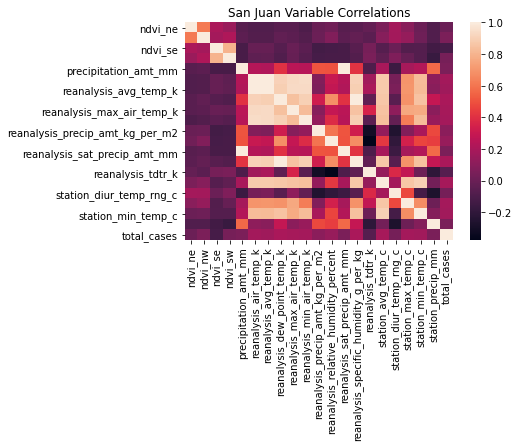

In [18]:
# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

Text(0.5, 1.0, 'Iquitos Variable Correlations')

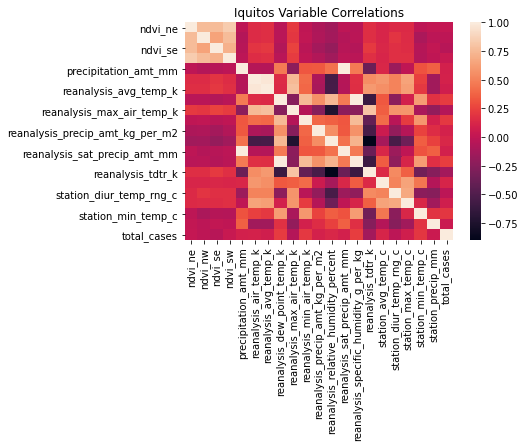

In [19]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations)
plt.title('Iquitos Variable Correlations')

### Many of the temperature data are strongly correlated, which is expected. But the `total_cases` variable doesn't have many obvious strong correlations.

Interestingly, `total_cases` seems to only have weak correlations with other variables. Many of the climate variables are much more strongly correlated. Interestingly, the vegetation index also only has weak correlation with other variables. These correlations may give us some hints as to how to improve our model that we'll talk about later in this post. For now, let's take a `sorted` look at `total_cases` correlations.

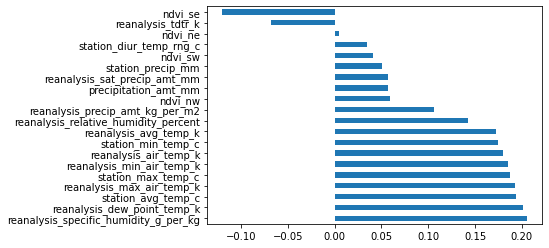

In [20]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

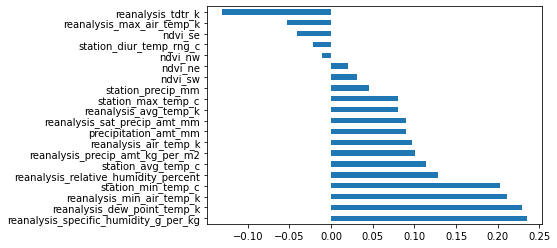

In [21]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

### A few observations

#### The wetter the better
* The correlation strengths differ for each city, but it looks like `reanalysis_specific_humidity_g_per_kg` and `reanalysis_dew_point_temp_k` are the most strongly correlated with `total_cases`. This makes sense: we know mosquitos thrive in _wet_ climates, the wetter the better!

#### Hot and heavy
* As we all know, "cold and humid" is not a thing. So it's not surprising that as minimum temperatures, maximum temperatures, and average temperatures rise, the `total_cases` of dengue fever tend to rise as well.

#### Sometimes it rains, so what
* Interestingly, the `precipitation` measurements bear little to no correlation to `total_cases`, despite strong correlations to the `humidity` measurements, as evident by the heatmaps above.

### This is just a first pass

Precisely _none_ of these correlations are very strong. Of course, that doesn't mean that some **feature engineering wizardry** can't put us in a better place **(`standing_water` estimate, anyone?)**. Also, it's always useful to keep in mind that **life isn't linear**, but out-of-the-box correlation measurement is – or at least, it measures linear dependence.

Nevertheless, for this tutorial we'll focus on the linear __wetness__ trend we see above, and reduce our inputs to...

#### a few good variables:

* `reanalysis_specific_humidity_g_per_kg`
* `reanalysis_dew_point_temp_k`
* `station_avg_temp_c`
* `station_min_temp_c`

## Let's (scikit)-learn

Now that we've explored this data and picked some input variables, it's time to start modeling. 

We will be using the [**scikit-learn**](https://scikit-learn.org/stable/) (a.k.a. sklearn) library for machine learning. It's a mature library with a comprehensive set of tools and good documentation. It also has an opinionated design that emphasizes reuse and reproducibility through its object-oriented style and "pipeline" concepts. We highly recommend starting with scikit-learn for most machine learning situations.

### Choosing a modeling approach

When doing a first-pass model, it's usually a good idea to start with a linear model. As discussed earlier, we're trying to predict **counts**. The generalized linear model family has two models for modeling counts:

1. Poisson regression
2. Negative binomial regression

Poisson regression is the simpler model and fits according to the assumption that the mean and variance of the population distribution are equal. 

When the mean and variance aren't equal, specifically when the variance is much larger than the mean, the negative binomial approach is better. Why? It isn't magic. The negative binomial regression simply lifts the assumption that the population mean and variance are equal, allowing for a larger class of possible models. In fact, from this perspective, the Poisson distribution is but a special case of the negative binomial distribution.

Since scikit-learn has a [`PoissonRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html) implementation, but not one for negative binomial regression, we'll be doing Poisson regression for this first-pass model.

We can, however, check the assumptions really quickly:

In [22]:
print('San Juan')
print('mean: ', sj_train_labels.mean()[0])
print('var :', sj_train_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_train_labels.mean()[0])
print('var :', iq_train_labels.var()[0])

San Juan
mean:  34.18055555555556
var : 2640.0454396910277

Iquitos
mean:  7.565384615384615
var : 115.89552393656439


It does indeed look like the variance is much higher than the mean for both city's count distributions! This suggests that negative binomial distribution is a better choice statistically, and we have an obvious avenue for the next iteration.

Let's get started on the modeling by importing the parts of scikit-learn that we will be using.

In [23]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from sklearn.model_selection import train_test_split

from sklearn.linear_model import PoissonRegressor

# For pipeline visualization
from sklearn import set_config
set_config(display='diagram') 

### Loading and splitting data

First, let's load the training data again so we have clean, fresh dataframes that haven't been modified. 

In [24]:
# Let's make a function since we'll be splitting by city a lot
def load_data(data_path):
    """Load data, sorts by time, and split by city"""
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    return df.loc["sj"], df.loc["iq"]

sj_features_df, iq_features_df = load_data(DATA_DIR / "dengue_features_train.csv")
sj_labels_df, iq_labels_df = load_data(DATA_DIR / "dengue_labels_train.csv")

print("sj_features_df", sj_features_df.shape)
print("iq_features_df", iq_features_df.shape)
print("sj_labels_df", sj_labels_df.shape)
print("iq_labels_df", iq_labels_df.shape)

sj_features_df (936, 21)
iq_features_df (520, 21)
sj_labels_df (936, 1)
iq_labels_df (520, 1)


Next, we'll split our data into training and evaluation. It's important when evaluating model performance to do so on data that was not used for training. Evaluating and training on the same data leads to an overconfident evaluation. Since we have time series data, we'll do a strict-future holdout for our evaluation. Our data is already sorted by time, so we can use sklearn's `train_test_split` function _without shuffling_.

In [25]:
sj_X_train, sj_X_eval, sj_y_train, sj_y_eval = train_test_split(
    sj_features_df,
    sj_labels_df,
    test_size=0.25,
    shuffle=False,
)

iq_X_train, iq_X_eval, iq_y_train, iq_y_eval = train_test_split(
    iq_features_df,
    iq_labels_df,
    test_size=0.25,
    shuffle=False,
)

### Data Preprocessing

Now let's define our preprocessing steps. We'll be doing two main things:
- **Scaling**: This step is not critical but often useful to generally do as a rule of thumb. In our case, scaling will help the model regularize features more effectively. It will also give us model weights that can be compared across features and interpreted as feature importances. 
- **Missing Value Imputation**: This step is necessary. Most machine learning models don't handle missing values. Because we have a time series problem, we'll use forward-fill imputation as a first pass approach, where we fill using the previous timestep's value. 

sklearn doesn't have a forward-fill imputation transformer, so we'll need to make our own. This is a good demonstration of sklearn's `FunctionTransformer` class, which you can use to implement simple functions into sklearn transformers. We define a function `forward_fill` which takes a numpy array, uses the `ffill` functionality from pandas, and then returns the data back as a numpy array.

In [26]:
def forward_fill(array):
    return pd.DataFrame(array).ffill().values

forward_imputer = FunctionTransformer(forward_fill)

Next, we'll stitch together our preprocessing steps into a preprocessor object that can be fitted and reused. We will use the `ColumnTransformer` class, which is the way sklearn expects you to pull columns out of a pandas dataframe and apply data transformations. In setting up the `ColumnTransformer`, we chain together our two preprocessing steps into one transformer using `Pipeline`, and then we set that we want to apply it to our subset of features. We will have the `ColumnTransformer` drop the remainder of the dataframe columns. 

In [27]:
features_to_use = [
    "reanalysis_specific_humidity_g_per_kg", 
    "reanalysis_dew_point_temp_k", 
    "station_avg_temp_c", 
    "station_min_temp_c"
]

preprocessing_steps = Pipeline([
    ("standard_scaler", StandardScaler()),
    ("forward_imputer", forward_imputer)
])

sj_preprocessor = ColumnTransformer(
    transformers = [
        ("features", preprocessing_steps, features_to_use)
    ],
    remainder = "drop"
)

We actually will need a second preprocessor object. This is because the scaling is fit to data, so we need one for San Juan and another for Iquitos. You'll notice we named the preprocessor we just created `sj_preprocessor`. We can use the `clone` function make a copy for `iq`. 

In [28]:
iq_preprocessor = clone(sj_preprocessor)

## Pipeline

Now we'll wrap up our full modeling workflow, including the Poisson Regression model itself, into sklearn `Pipeline` objects. We used these earlier to chain our scaling and imputation. Pipelines encapsulate everything into one object with one interface, which makes it easy to train a model, save it to one file for later (e.g., by [pickling](https://docs.python.org/3/library/pickle.html)), reload it, and use it again. It's a valuable tool in making your machine learning models reusable and reproducible.

In [29]:
sj_pipeline = Pipeline([
    ("preprocessor", sj_preprocessor),
    ("estimator", PoissonRegressor())
])

iq_pipeline = Pipeline([
    ("preprocessor", iq_preprocessor),
    ("estimator", PoissonRegressor())
])

iq_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('features',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('forward_imputer',
                                                                   FunctionTransformer(func=<function forward_fill at 0x7f97cc150ca0>))]),
                                                  ['reanalysis_specific_humidity_g_per_kg',
                                                   'reanalysis_dew_point_temp_k',
                                                   'station_avg_temp_c',
                                                   'station_min_temp_c'])])),
                ('estimator', PoissonRegressor())])

Now, let's fit our models and evaluate them!

In [30]:
sj_pipeline.fit(sj_X_train, sj_y_train)
iq_pipeline.fit(iq_X_train, iq_y_train)

sj_preds = sj_pipeline.predict(sj_X_eval)
iq_preds = iq_pipeline.predict(iq_X_eval)

We'll plot the predictions against the true case counts for both models. 

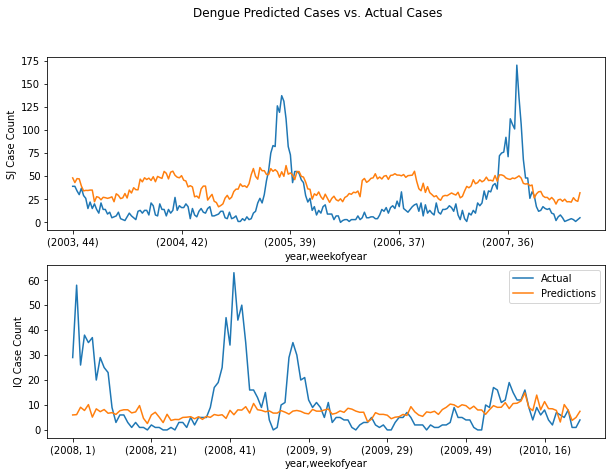

In [31]:
figs, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,7))

sj_y_eval.plot(ax=axes[0],legend=None)
axes[0].plot(sj_preds, label="Predictions")
axes[0].set_ylabel("SJ Case Count")

iq_y_eval.rename(columns={"total_cases": "Actual"}).plot(ax=axes[1])
axes[1].plot(iq_preds, label="Predictions")
axes[1].set_ylabel("IQ Case Count")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()
None

## Reflecting on our performance

These graphs can actually tell us a lot about where our model is going wrong and give us some good hints about where investments will improve the model performance. 

For example, we see that our model in orange does track the seasonality of dengue cases. However, the timing of the seasonality of our predictions has a mismatch with the actual results. One potential reason for this is that our features don't look far enough into the past—that is to say, we are asking to predict cases at the same time as we are measuring percipitation. Because dengue is mosquito-borne, and the mosquito lifecycle depends on water, we need to take both the life of a mosquito and the time between infection and symptoms into account when modeling dengue. This is a critical avenue to explore when improving this model.

The other important error is that our predictions are relatively consistent—we miss the spikes that are large outbreaks. One reason is that we don't take into account the contagiousness of dengue. A possible way to account for this is to build a model that progressively predicts a new value while taking into account the previous prediction. By training on the dengue outbreaks and then using the predicted number of patients in the week before, we can start to model this time dependence that the current model misses.

We also know that Poisson regression is not the best-suited for this dataset. We saw earlier than our variance in counts is higher than the mean, making it negative binomial regression more appropriate. While sklearn doesn't offer negative binomial regression, we could use the [statsmodel](https://www.statsmodels.org/stable/generated/statsmodels.genmod.families.family.NegativeBinomial.html) package. We can also take advantage of sklearn's extendability to wrap statsmodel's `NegativeBinomial` model inside custom sklearn estimator, so that we can plug it into our sklearn pipeline. More about custom sklearn estimators is available in their [documentation](https://scikit-learn.org/stable/developers/develop.html#rolling-your-own-estimator). 

So, we know we're not going to win this thing, but let's submit the predictions anyway!

### Generating a submission

First, we want to retrain our models on the full dataset.

In [32]:
sj_pipeline.fit(sj_features_df, sj_labels_df)
iq_pipeline.fit(iq_features_df, iq_labels_df)
None # Don't print diagram

Now, we'll load our test data and generate predictions.

In [33]:
sj_test_df, iq_test_df = load_data(DATA_DIR / "dengue_features_test.csv")

print("sj_test_df", sj_test_df.shape)
print("iq_test_df", iq_test_df.shape)

sj_test_df (260, 21)
iq_test_df (156, 21)


In [34]:
sj_test_preds = sj_pipeline.predict(sj_test_df)
iq_test_preds = iq_pipeline.predict(iq_test_df)

Then, we'll load up the submission format and plug our predictions in. 

In [35]:
OUTPUT_DIR = PROJ_ROOT / "data" / "processed"
print("OUTPUT_DIR : ", OUTPUT_DIR)

OUTPUT_DIR :  /Users/jqi/repos/intro-to-reproducible-ml/data/processed


In [36]:
sj_submission_df, iq_submission_df = load_data(DATA_DIR / "submission_format.csv")

sj_submission_df["total_cases"] = sj_test_preds.astype(int)
iq_submission_df["total_cases"] = iq_test_preds.astype(int)

# Rejoin SJ and IQ together. 
submission_df = pd.concat({
    "sj": sj_submission_df, 
    "iq": iq_submission_df
}, names=["city"])

# order reorder based on original order

submission_df.to_csv(OUTPUT_DIR / "submission.csv")

submission_df.head(10)

total_cases
city year weekofyear             
sj   2008 18                   28
          19                   26
          20                   36
          21                   29
          22                   31
          23                   33
          24                   35
          25                   41
          26                   43
          27                   42

Head to the [competition submission page](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/submissions/) and submit the predictions.

<img src="https://drivendata-public-assets.s3.amazonaws.com/gtf-intro-to-reproducible-ml-submission.png" alt="Submission" width="500" />

Alright, it's a start! 